![](./images/JN_header.jpg)

# On Shaky Ground
---
**Author:**  [Ted Brandon](https://github.com/theobigdog)

## Introduction
---
Most everyone, even those who don't live in prone areas, knows about the awesome, yet devastating power of earthquakes, with caveats of landslides, liquifaction and tsunami.  All of these aspects, combined, form a great threat to human lives, as well as infrastucture, dwellings, businesses, all other structures, etc.,...  On March 11, 2011, a M-9.0 earthquake off the east coast of Japan caused a tsunami that not only wreaked havoc, as described above, but also led to one of the worst nuclear catastrophies the world has seen.  Estimated death count for this event is ~20,000 with an estimation of \\$220 billion USD in damages in Japan alone.  On December 26, 2004, a M-9.1 earthquake off the coast of Sumatra-Andaman caused a tsunami that hit all nearby islands and most nearby countries, including Indonesia, Sri Lanka, India, Maldives and Thailand.  This earthquake resulted in the loss of at least 225,000 human lives, and damages of ~\\$15 billion USD.  January 12, 2010, a M-7.0 earthquake in Haiti caused such excessive damage to person and property that, 10 years later, the country has still not recovered.

## Business Understanding
---
Formed in 2009, The Earthquake Disaster Assistance Team (EDAT) is an international rapid response team under the USGS umbrella.

## Data Understanding
---
All data come from the Kaggle ["Significant Earthquakes, 1965-2016"](https://www.kaggle.com/usgs/earthquake-database) dataset, which includes the date, time and location of all earthquakes with a magnitude of 5.5 or higher.  The set contains ~23,000 entries with 21 features(columns), including, in addition to the above, such information as type, depth, seismic stations, magnitude types, amongst others.  

In [1]:
# Import the goodies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools

Load data into a df, combine `Date` and `Time` to make a new feature, which can then be converted to a "date-time" object.

In [2]:
df = pd.read_csv('data/Significant_Earthquakes_1965-2016.csv')

df['Date_Time'] = df['Date'] + ' ' + df['Time']
df_dt = df.drop('Date', axis=1).drop('Time', axis=1)
dt = df_dt['Date_Time']
df_dt.drop('Date_Time', axis=1, inplace=True)
df_dt = pd.concat([dt, df_dt], axis=1)

#Rows 3378, 7512, 20650 have date-times in a different format, so we'll drop them.
df_dt.drop([3378,7512,20650], inplace=True)

df_dt['Date_Time'] = pd.to_datetime(df_dt['Date_Time'])
df_dt.reset_index(drop=True)
df_dt.head(1)

,Date_Time,Latitude,Longitude,Type,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Type,Magnitude Error,Magnitude Seismic Stations,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square,ID,Source,Location Source,Magnitude Source,Status
0,1965-01-02 13:44:18,19.246,145.616,Earthquake,131.6,NaN,NaN,6.0,MW,NaN,NaN,NaN,NaN,NaN,NaN,ISCGEM860706,ISCGEM,ISCGEM,ISCGEM,Automatic


## Start the EDA process

In [3]:
#dropping all entries that are not actual Earthquakes (no Nuclear Explosions, Explosions or Rock Bursts)
df_eq = df_dt[df_dt['Type'] == 'Earthquake'].reset_index(drop=True)

Multiple columns are missing too much data, so I will drop them here, "Type" is dropped because
all entries are "Earthquake" due to the way the data have thus far been processed.

In [4]:
drop_cols = ['Type','Depth Error','Depth Seismic Stations','Magnitude Error','Magnitude Seismic Stations','Azimuthal Gap',\
            'Horizontal Distance','Horizontal Error','Root Mean Square']
df_trim = df_eq.drop(drop_cols, axis=1)

Summary of usable data:

In [6]:
df_len = len(df)
df_trim_len = len(df_trim)
diff = df_len - df_trim_len
loss = diff/df_len*100

print(str(df_len) + ' entries to start.  With cleanup, we now have '\
     + str(df_trim_len) + ' remaining.  This is a loss of ' + str(loss) + '%.')

23412 entries to start.  With cleanup, we now have 23229 remaining.  This is a loss of 0.7816504356740134%.


## Earthquake Map

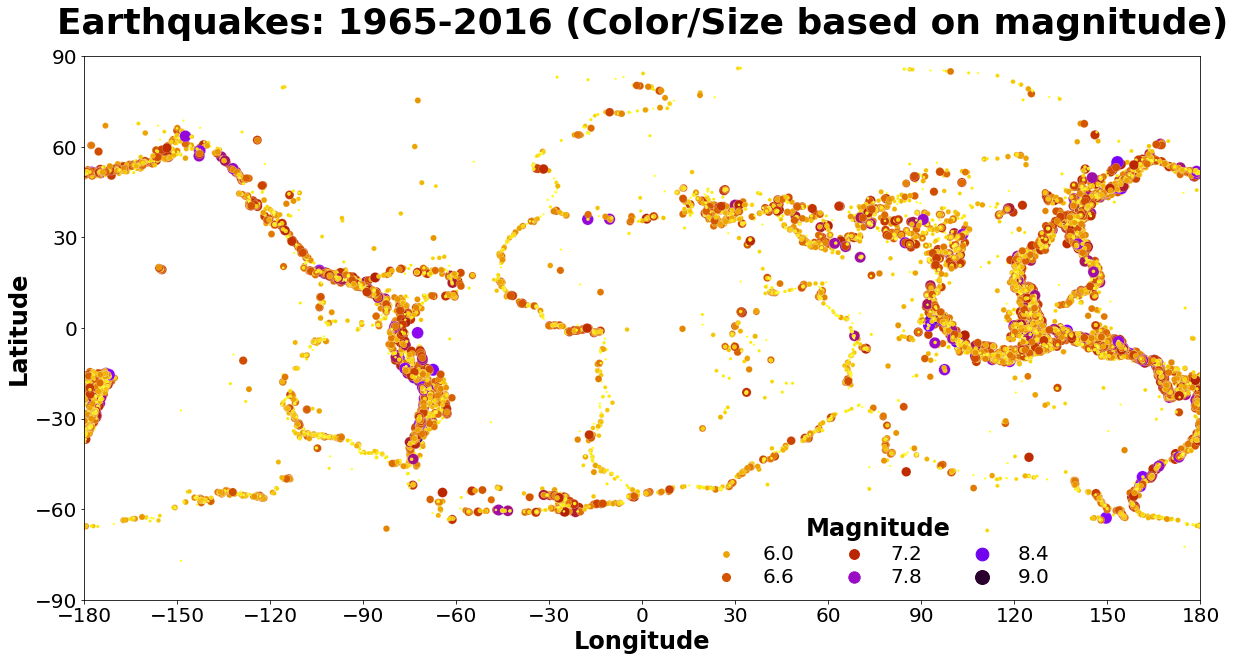

In [7]:
df_trunc = df_trim.copy()
lat_30 = [-90,-60,-30,0,30,60,90]
long_30 = [-180,-150,-120,-90,-60,-30,0,30,60,90,120,150,180]

fig, ax = plt.subplots(figsize=(20,10))
sns.scatterplot(x=df_trunc['Longitude'], y=df_trunc['Latitude'], hue=df_trunc['Magnitude'],
                size=df_trunc['Magnitude'], sizes=(5,200),marker='o',palette='gnuplot_r')
# leg_col = '#f7f7f7' # For overlay
leg_col = 'black' # For notebook
legend = plt.legend(title='Magnitude', title_fontsize=24, fontsize=20, labelspacing=0.2,
                loc=(0.55,0.01), ncol=3, frameon=False, labelcolor=leg_col)
plt.setp(legend.get_title(), color =leg_col, fontweight='bold')
ax.set_ylim([-90,90])
plt.title('Earthquakes: 1965-2016 (Color/Size based on magnitude)', fontsize=36,
          fontweight='bold', y=1.03)
plt.xlabel('Longitude', fontsize=24, fontweight='bold')
plt.yticks(lat_30, fontsize=20)
ax.set_xlim([-180,180])
plt.ylabel('Latitude', fontsize=24, fontweight='bold')
plt.xticks(ticks=(long_30), fontsize=20);
# plt.savefig('images/earthquake_map_presentation.png', transparent=True, dpi=300) # Export for presentation
# plt.savefig('images/earthquake_map_notebook.png', dpi=300) # Export for notebook

## Feature Engineering

I want to see if binning this by month or season will provide useful information.

In [8]:
df_binned = df_trunc.copy()
df_binned['Month'] = pd.DatetimeIndex(df_binned['Date_Time']).month

season = {1 : 'Winter', 2 : 'Winter', 3 : 'Spring', 4 : 'Spring', 5 : 'Spring', 6 : 'Summer',
         7 : 'Summer', 8 : 'Summer', 9 : 'Fall', 10 : 'Fall', 11 : 'Fall', 12 : 'Winter'}

df_binned['Season'] = df_binned['Month'].map(season)

## Country names were generated, based on Lats/Longs

Since I will eventually pare this down to just Asian countries, the next few blocks of code were written to identify the country that experienced a given earthquake.  The first step used `Latitude` and `Longitude` and `reverseGeocode` to generate a `Country` column.  The entries in this column are long, single strings of information which needed to be trimmed to recover the country codes ("cc").

The `reverseGeocode` step took about 4hr to complete, so these intermediate results were backed-up as a csv.  The `country_converter` function took a while as well, so these converted results were separately backed-up.  The final saved csv allows for these time-demanding steps to be bypassed in the future.

In [9]:
df_lat_long = df_binned.copy()
lat_long = []
for i in range(len(df_lat_long['Latitude'])):
    lat_long.append([df_lat_long['Latitude'][i], df_lat_long['Longitude'][i]])

In [10]:
# import reverse_geocoder as rg

# country_list = [rg.search(x) for x in lat_long]

In [11]:
# This was only used once to create the final csv.  Do not use again

# #!pip install reverse_geocoder
# import reverse_geocoder as rg
# from pandas import DataFrame

# def reverseGeocode(coordinates):
#     return rg.search(coordinates)

# df_countries = df_magn.copy()
# df_countries['Country'] = df_countries['Lat_Long'].apply(reverseGeocode)

# df_countries.to_csv('data/df_countries.csv')

# #!pip install country_converter
# import country_converter as coco

# def get_cc (info_string : str) -> str:
#     cc_pre = (info_string.split("'cc': '",1)[1])
#     cc = cc_pre[:-3]
#     return cc

# def convert_cc (cc : str) -> str:
#     name = coco.convert(names=cc, to='name_short')
#     return name

# df_countries['Country_Code'] = df_countries['Country'].apply(get_cc)

# df_countries['Country'] = df_countries['Country_Code'].apply(convert_cc)

# df_countries.to_csv('data/fixed_countries.csv')

### A new df, containing appropriate country names was then imported

In [12]:
df_countries = pd.read_csv('data/fixed_countries.csv')

Going to need latitude/longitude in list-form, down the line

In [13]:
# lat_long = []
# for i in range(len(df_countries['Latitude'])):
#     lat_long.append([round(df_countries['Latitude'][i],3), round(df_countries['Longitude'][i],3)])
# df_countries['Lat_Long'] = lat_long

### Now we can identify each earthquake as occurring in asia, by using the following function to check for presence in the following [list of asian countries](https://www.countries-ofthe-world.com/countries-of-asia.html):

In [14]:
def is_asian(country):
    asia = ['Afghanistan','Armernia','Azerbaijan','Bahrain','Bangladesh','Bhutan','Brunei',
           'Cambodia','China','Cyprus','Georgia','India','Indonesia','Iran','Irag','Israel',
           'Japan','Jordan','Kazakhstan','Kuwait','Kyrgyzstan','Laos','Lebanon','Malaysia',
           'Maldives','Mongolia','Myanmar','Nepal','North Korea','Oman','Pakistan','Palestine',
           'Philippines','Qatar','Russia','Saudi Arabia','Singapore','South Korea','Sri Lanka',
           'Syria','Taiwan','Tajikistan','Thailand','Timor-Leste','Turkey','Turkmenistan','UAE',
           'United Arab Emirates','United Arab Emirates (UAE)','Uzbekistan','Vietnam','Yemen']
    if country in asia:
        asian = 1
    else:
        asian = 0
    return asian

df_countries['In_Asia'] = df_countries['Country'].apply(is_asian)

In [15]:
total_earthquakes = len(df_countries)
asian_earthquakes = df_countries['In_Asia'].value_counts()[1]
non_asian_earthquakes = df_countries['In_Asia'].value_counts()[0]
percent_asian = round(df_countries['In_Asia'].value_counts('1')[1] * 100, 2)

print('There are ' + str(total_earthquakes) + ' earthquakes in the initial data set.')
print(str(asian_earthquakes) + ' of these occurred in Asian countries,')
print('leaving ' + str(non_asian_earthquakes) + ' occurring in the rest of the world.')
print('This means that earthquakes in Asia accounted for ' + str(percent_asian) + '% of the\
 world total from 1965 through 2016.')

There are 22820 earthquakes in the initial data set.
8804 of these occurred in Asian countries,
leaving 14016 occurring in the rest of the world.
This means that earthquakes in Asia accounted for 38.58% of the world total from 1965 through 2016.


In [16]:
df_asian = df_countries[df_countries['In_Asia'] == 1].reset_index(drop=True)

In [17]:
#  Oops!  Extra indices from the two "big" engineered features.  Dropping:

drop_indices = ['Unnamed: 0','Unnamed: 0.1']
df_asian = df_asian.drop(drop_indices, axis=1)

### Plot of Asian Earthquakes

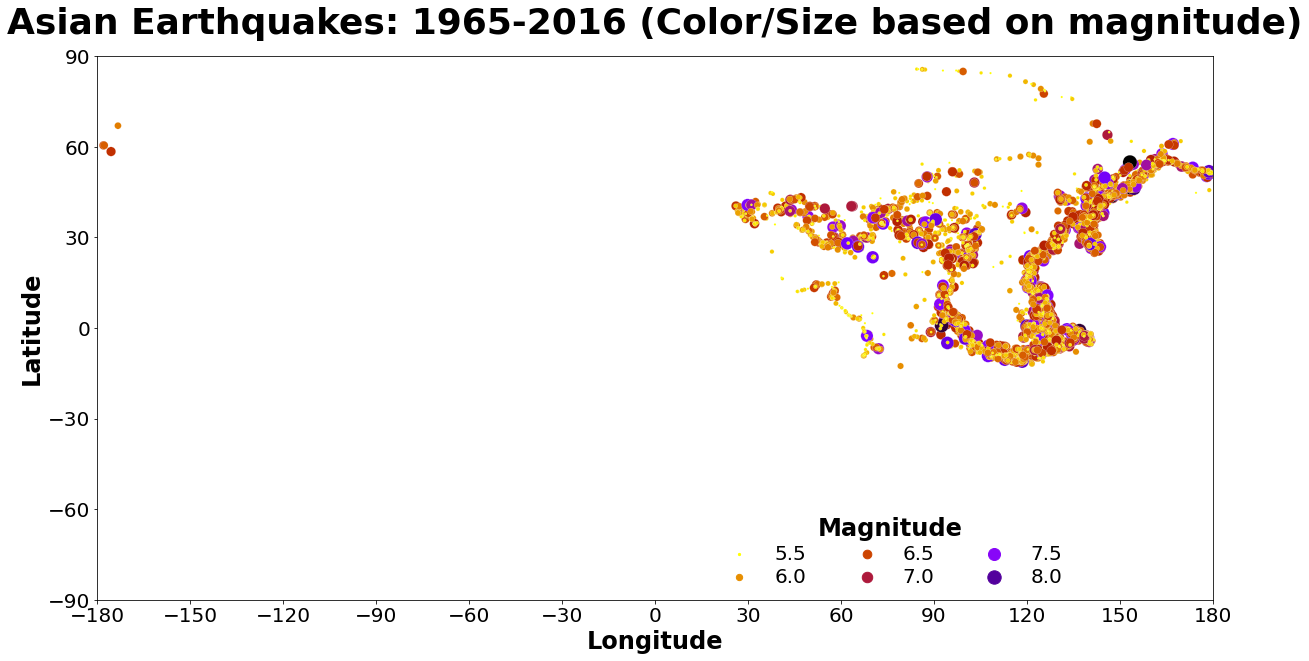

In [18]:
fig, ax = plt.subplots(figsize=(20,10))
sns.scatterplot(x=df_asian['Longitude'], y=df_asian['Latitude'], hue=df_asian['Magnitude'],
                size=df_asian['Magnitude'], sizes=(5,200),marker='o',palette='gnuplot_r')
# leg_col = '#f7f7f7' # For overlay
leg_col = 'black' # For notebook
legend = plt.legend(title='Magnitude', title_fontsize=24, fontsize=20, labelspacing=0.2,
                loc=(0.55,0.01), ncol=3, frameon=False, labelcolor=leg_col)
plt.setp(legend.get_title(), color =leg_col, fontweight='bold')
ax.set_ylim([-90,90])
plt.title('Asian Earthquakes: 1965-2016 (Color/Size based on magnitude)', fontsize=36,
          fontweight='bold', y=1.03)
plt.xlabel('Longitude', fontsize=24, fontweight='bold')
plt.yticks(lat_30, fontsize=20)
ax.set_xlim([-180,180])
plt.ylabel('Latitude', fontsize=24, fontweight='bold')
plt.xticks(ticks=(long_30), fontsize=20);
# plt.savefig('images/asian_earthquake_map_presentation.png', transparent=True, dpi=300) # Export for presentation
# plt.savefig('images/asian_earthquake_map_notebook.png', dpi=300) # Export for notebook

Somehow, the Date_Time column was re-converted to "object" so I'll fix that now:

In [20]:
df_asian['Date_Time'] = pd.to_datetime(df_asian['Date_Time']).reset_index(drop=True)

In [21]:
# Going to look at all points together, instead of binning the magnitude ranges, per Max

asian_ts = pd.Series(df_asian.set_index(df_asian['Date_Time'])['Magnitude'])

# And now we'll resample to Monthly sum and see how it looks

monthly_sum_asian = asian_ts.resample('M').sum()

# We'll make a Monthly mean now too for funsies

monthly_mean_asian = asian_ts.resample('M').mean()


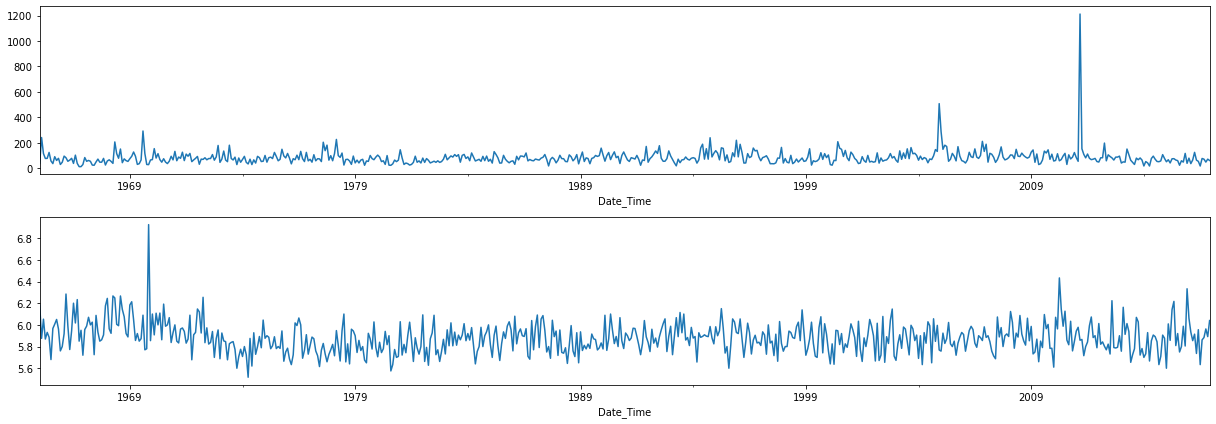

In [22]:
fig, axs = plt.subplots(2, 1, figsize=(17,6), tight_layout=True)

ax = axs[0]
monthly_sum_asian.plot(ax=ax)
ax=axs[1]
monthly_mean_asian.plot(ax=ax);

#### Dickey-Fuller

In [23]:
from statsmodels.tsa.stattools import adfuller

def run_df(ts):
    df_rslt = adfuller(ts)
    print("Dickey_Fuller test results:  \n")
    df_output = pd.Series(df_rslt[0:4], index=['Test Statistic','p-value',\
                                              '#Lags Used','Number of Observations Used'])
    for key, value in df_rslt[4].items():
        df_output['Critical Value (%s)'%key] = value
    print(df_output)

In [24]:
run_df(asian_ts)

Dickey_Fuller test results:  

Test Statistic                  -20.419307
p-value                           0.000000
#Lags Used                       14.000000
Number of Observations Used    8789.000000
Critical Value (1%)              -3.431094
Critical Value (5%)              -2.861869
Critical Value (10%)             -2.566945
dtype: float64


In [25]:
# Let's do the same thing now, but with the data resampled as "Daily"

daily_sum_asian = asian_ts.resample('D').sum()

daily_mean_asian = asian_ts.resample('D').mean()

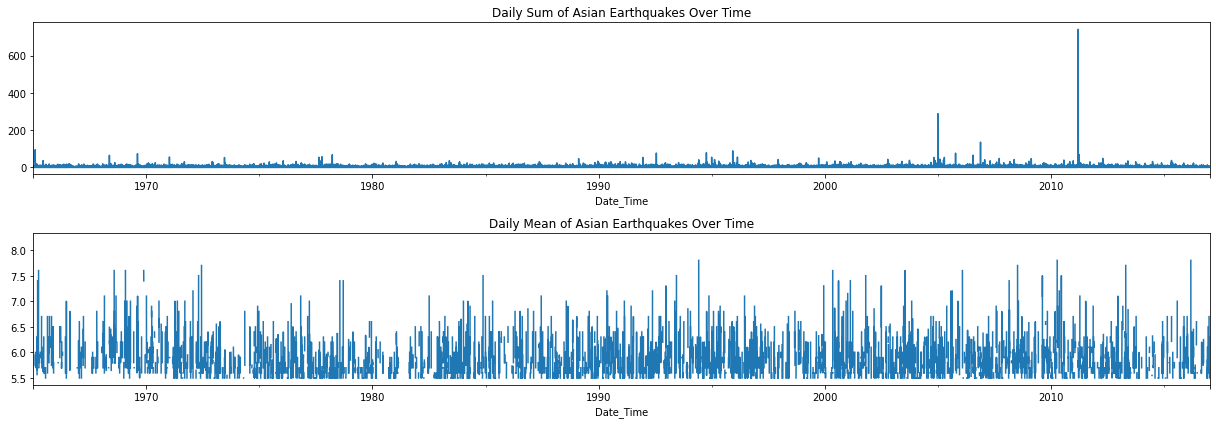

In [26]:
fig, axs = plt.subplots(2, 1, figsize=(17,6), tight_layout=True)

ax=axs[0]

daily_sum_asian.plot(ax=ax)
ax.set_title('Daily Sum of Asian Earthquakes Over Time')
ax=axs[1]
daily_mean_asian.plot(ax=ax)
ax.set_title('Daily Mean of Asian Earthquakes Over Time');

In [27]:
# and now "weekly"

weekly_sum_asian = asian_ts.resample('W').sum()

weekly_mean_asian = asian_ts.resample('W').mean()

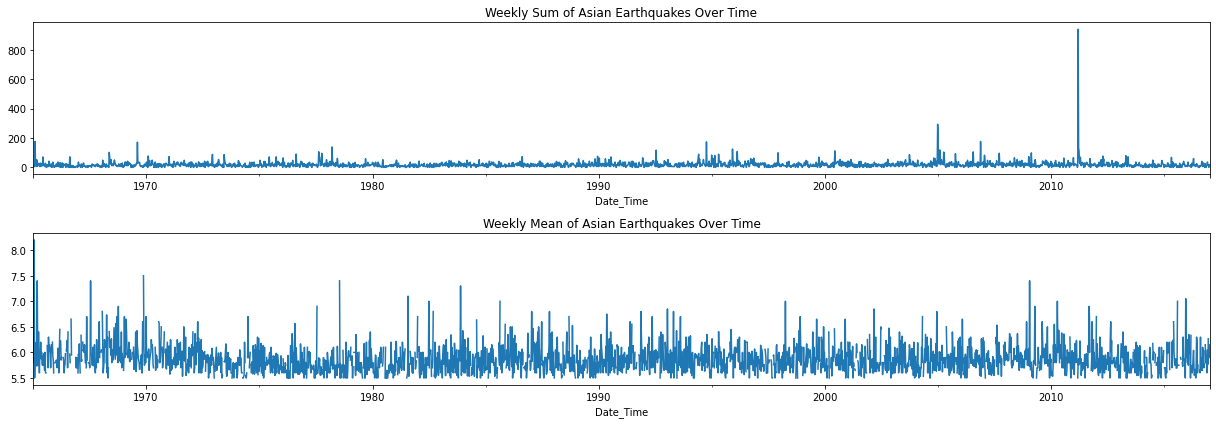

In [28]:
fig, axs = plt.subplots(2, 1, figsize=(17,6), tight_layout=True)

ax=axs[0]

weekly_sum_asian.plot(ax=ax)
ax.set_title('Weekly Sum of Asian Earthquakes Over Time')
ax=axs[1]
weekly_mean_asian.plot(ax=ax)
ax.set_title('Weekly Mean of Asian Earthquakes Over Time');

### Let's do a train/test split on the weekly mean data:

In the case of time series, a random sampling of test samples is not going to work, so we'll just take the most recent 20% as the test, and the older 80% as the train

In [29]:
cutoff = round(weekly_mean_asian.shape[0] * 0.8)

In [30]:
train = weekly_mean_asian[:cutoff]
test = weekly_mean_asian[cutoff:]

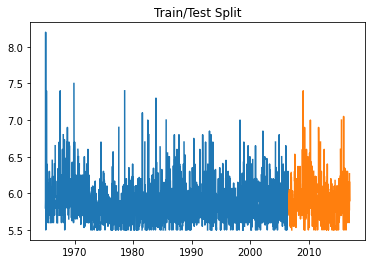

In [31]:
fig, ax = plt.subplots()
ax.plot(train)
ax.plot(test)
ax.set_title('Train/Test Split');

# First Simple Model (FSM) => Random Walk

In [32]:
# The "shift" operator predicts where the next point (week) will be
random_walk = train.shift(1)

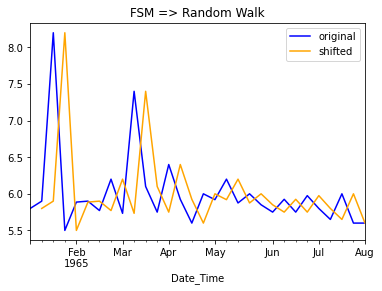

In [33]:
# plot the Random Walk:

fig, ax = plt.subplots()

train[0:30].plot(ax=ax, c='blue', label='original')
random_walk[0:30].plot(ax=ax, c='orange', label='shifted')
ax.set_title('FSM => Random Walk')
ax.legend();

For a baseline to compare with future models, the RMSE will be needed:

In [34]:
np.sqrt(mean_squared_error(train.dropna()[1:], random_walk.dropna()))

0.37537675871901716

RMSE calculated a different way, in order to plot residuals:

In [35]:
residuals = random_walk[1:] - train[1:]
mse = (residuals**2).sum()/len(residuals-1)
np.sqrt(mse)

0.3400342492269958

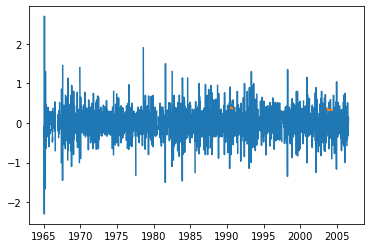

In [36]:
# plotting residuals:

fig, ax = plt.subplots()

ax.plot(residuals.index, residuals)
ax.plot(residuals.index, residuals.rolling(52).std());

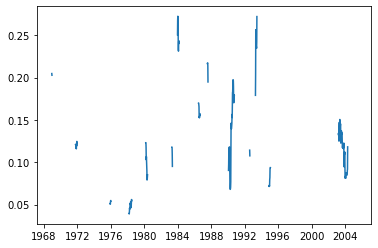

In [37]:
fig, ax = plt.subplots()

ax.plot(residuals.index, residuals.rolling(30).var());

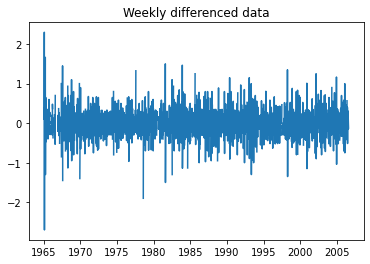

In [38]:
# Differenced data (more like white noise):

fig, ax = plt.subplots()
ax.plot(train.diff())
ax.set_title('Weekly differenced data');

# Trying a "second" FSM with monthly means instead of weekly

In [39]:
monthly_mean_asian = asian_ts.resample('MS').mean()

In [40]:
cutoff = round(monthly_mean_asian.shape[0] * 0.8)

In [41]:
train = monthly_mean_asian[:cutoff]
test = monthly_mean_asian[cutoff:]

In [42]:
print(monthly_mean_asian.mean())
print(monthly_mean_asian.std())
print(train.mean())
print(train.std())
print(test.mean())
print(test.std())

5.879476028328183
0.14237964198432423
5.877374643761405
0.14172069021527334
5.887864755518765
0.1452535397976334


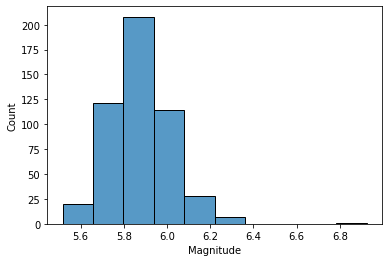

In [43]:
sns.histplot(train, bins=10);

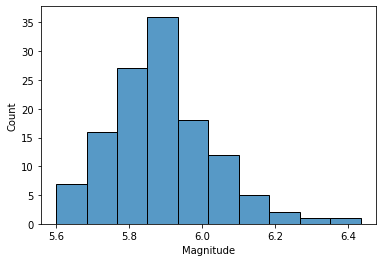

In [44]:
sns.histplot(test, bins=10);

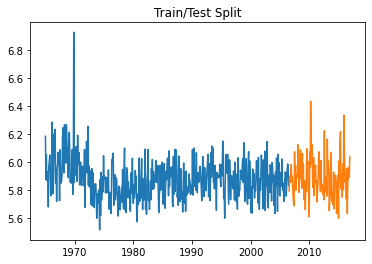

In [45]:
fig, ax = plt.subplots()
ax.plot(train)
ax.plot(test)
ax.set_title('Train/Test Split');

In [46]:
train

Date_Time
1965-01-01    6.183333
1965-02-01    5.875610
1965-03-01    6.052632
1965-04-01    5.869231
1965-05-01    5.930769
                ...   
2006-03-01    5.854545
2006-04-01    5.947619
2006-05-01    5.986667
2006-06-01    5.957143
2006-07-01    5.830769
Freq: MS, Name: Magnitude, Length: 499, dtype: float64

In [47]:
random_walk = train.shift(1)

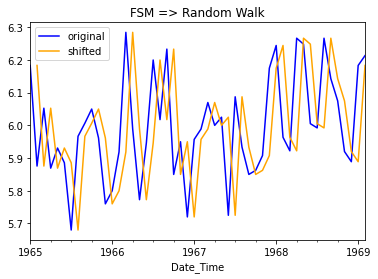

In [48]:
fig, ax = plt.subplots()

train[0:50].plot(ax=ax, c='blue', label='original')
random_walk[0:50].plot(ax=ax, c='orange', label='shifted')
ax.set_title('FSM => Random Walk')
ax.legend();

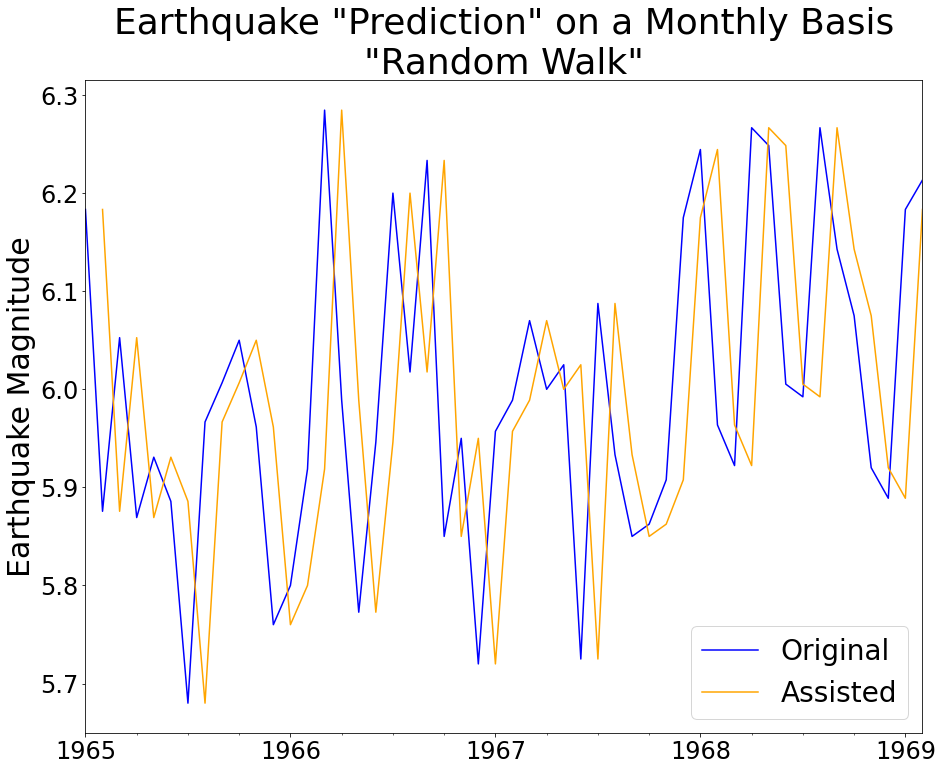

In [49]:
fig, ax = plt.subplots(figsize=(15,12))

train[0:50].plot(ax=ax, c='blue', label='Original')
random_walk[0:50].plot(ax=ax, c='orange', label='Assisted')
ax.set_title('Earthquake "Prediction" on a Monthly Basis\n"Random Walk"', fontsize=36)
plt.ylabel('Earthquake Magnitude', fontsize=30)
plt.yticks(fontsize=24)
plt.xlabel('')
plt.xticks(fontsize=24)
ax.legend(fontsize=28,loc='lower right');
plt.savefig('images/random_walk.png', dpi=300)

In [50]:
np.sqrt(mean_squared_error(train.dropna()[1:], random_walk.dropna()))

0.1832753541487922

In [51]:
residuals = random_walk[1:] - train[1:]
mse = (residuals**2).sum()/len(residuals-1)
np.sqrt(mse)

0.1832753541487922

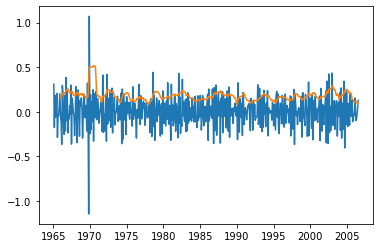

In [52]:
fig, ax = plt.subplots()

ax.plot(residuals.index, residuals)
ax.plot(residuals.index, residuals.rolling(12).std());

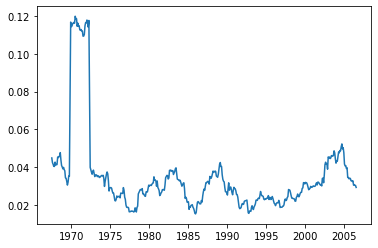

In [53]:
fig, ax = plt.subplots()

ax.plot(residuals.index, residuals.rolling(30).var());

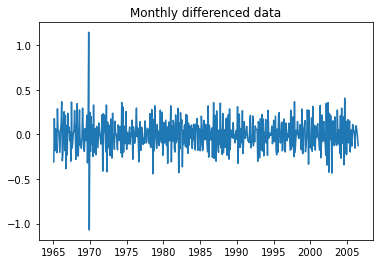

In [54]:
fig, ax = plt.subplots()
ax.plot(train.diff())
ax.set_title('Monthly differenced data');

# ARIMA
##### AR:  The prediction that today will be like previous days, with statsmodels object "p"
##### MA:  Moving average, accounts for short-run autocorrelation, with statsmodels object "q"
             "q" can be estimated from ACF plots

In [55]:
# Using Monthly data here (train2)

ar_1 = ARIMA(train, order=(1,1,0)).fit()
ar_1.predict(typ='levels')

Date_Time
1965-01-01    0.000000
1965-02-01    6.183333
1965-03-01    6.027948
1965-04-01    5.964997
1965-05-01    5.960023
                ...   
2006-03-01    5.833364
2006-04-01    5.806327
2006-05-01    5.901543
2006-06-01    5.967336
2006-07-01    5.971759
Freq: MS, Name: predicted_mean, Length: 499, dtype: float64

In [56]:
ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Magnitude   No. Observations:                  499
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 208.010
Date:                Tue, 30 Nov 2021   AIC                           -412.021
Time:                        18:03:27   BIC                           -403.599
Sample:                    01-01-1965   HQIC                          -408.716
                         - 07-01-2006                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4950      0.030    -16.543      0.000      -0.554      -0.436
sigma2         0.0254      0.001     28.774      0.000       0.024       0.027
===================================================================================
Ljung-Box (L1) (Q):                  12.42   Jarque-Bera (JB):               496.96
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.66   Skew:                             0.71
Prob(H) (two-sided):                  0.01   Kurtosis:                         7.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [57]:
ar_1.aic

-412.02060693033127

In [58]:
random_walk_model = ARIMA(train, order=(0,1,0)).fit()
random_walk_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Magnitude   No. Observations:                  499
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 138.358
Date:                Tue, 30 Nov 2021   AIC                           -274.716
Time:                        18:03:27   BIC                           -270.505
Sample:                    01-01-1965   HQIC                          -273.063
                         - 07-01-2006                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0336      0.001     27.922      0.000       0.031       0.036
===================================================================================
Ljung-Box (L1) (Q):                 121.66   Jarque-Bera (JB):               377.56
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.63   Skew:                             0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [59]:
print(f'Random Walk AIC:  {random_walk_model.aic}')
print(f'AR(1,1,0) AIC: {ar_1.aic}')

Random Walk AIC:  -274.71574799612824
AR(1,1,0) AIC: -412.02060693033127


In [60]:
y_hat_ar1 = ar_1.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat_ar1))

0.319367085014753

In [61]:
y_hat_rw = random_walk_model.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat_rw))

0.33187799602686885

In [62]:
ar_1.arparams

array([-0.49504772])

In [63]:
lr = LinearRegression()
lr.fit(np.array(train.diff().shift(1).dropna()).reshape(-1,1), train[1:].diff().dropna())
print(lr.coef_)

[-0.49324456]


In [64]:
ar_2 = ARIMA(train, order=(2,1,0)).fit()
ar_2.predict(typ='levels')

Date_Time
1965-01-01    0.000000
1965-02-01    6.183333
1965-03-01    6.027875
1965-04-01    6.036017
1965-05-01    5.932162
                ...   
2006-03-01    5.863983
2006-04-01    5.840454
2006-05-01    5.855310
2006-06-01    5.931105
2006-07-01    5.963872
Freq: MS, Name: predicted_mean, Length: 499, dtype: float64

In [65]:
y_hat_ar2 = ar_2.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat_ar2))

0.3152352648696354

In [66]:
print(f'AR(2,1,0) AIC: {ar_2.aic}')

AR(2,1,0) AIC: -464.55269261006816


In [67]:
ma_1 = ARIMA(train, order=(0,0,1)).fit()
y_hat = ma_1.predict(typ='levels')
y_hat

Date_Time
1965-01-01    5.877438
1965-02-01    5.916327
1965-03-01    5.872177
1965-04-01    5.900763
1965-05-01    5.873363
                ...   
2006-03-01    5.861437
2006-04-01    5.876548
2006-05-01    5.886625
2006-06-01    5.890369
2006-07-01    5.886069
Freq: MS, Name: predicted_mean, Length: 499, dtype: float64

In [68]:
ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Magnitude   No. Observations:                  499
Model:                 ARIMA(0, 0, 1)   Log Likelihood                 272.566
Date:                Tue, 30 Nov 2021   AIC                           -539.132
Time:                        18:03:27   BIC                           -526.494
Sample:                    01-01-1965   HQIC                          -534.172
                         - 07-01-2006                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.8774      0.008    765.977      0.000       5.862       5.892
ma.L1          0.1293      0.045      2.848      0.004       0.040       0.218
sigma2         0.0196      0.001     28.700      0.000       0.018       0.021
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):               786.57
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):               0.48   Skew:                             1.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [69]:
ma_1 = ARIMA(train, order=(0,1,1)).fit()

print(random_walk_model.aic)
print(ar_1.aic)
print(ar_2.aic)
print(ma_1.aic)

-274.71574799612824
-412.02060693033127
-464.55269261006816
-587.5244678402162


In [70]:
y_hat_ma1 = ma_1.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat_ma1))

0.30740632431800347

In [71]:
ma_2 = ARIMA(train, order=(0,1,2)).fit()
y_hat = ma_2.predict(typ='levels')

In [72]:
y_hat_ma2 = ma_2.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat_ma2))

0.30740261772971733

In [73]:
print(random_walk_model.aic)
print(ar_1.aic)
print(ar_2.aic)
print(ma_1.aic)
print(ma_2.aic)

-274.71574799612824
-412.02060693033127
-464.55269261006816
-587.5244678402162
-585.6031773182058


In [74]:
arma_21 = ARIMA(train, order=(2,1,2)).fit()

In [75]:
y_hat_arma21 = arma_21.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat_arma21))

0.3074017764991529

In [76]:
print(random_walk_model.aic)
print(ar_1.aic)
print(ar_2.aic)
print(ma_1.aic)
print(ma_2.aic)
print(arma_21.aic)

-274.71574799612824
-412.02060693033127
-464.55269261006816
-587.5244678402162
-585.6031773182058
-581.6171524317571


## ACF and PACF

F:\Flatiron\Anaconda2\envs\learn-env\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


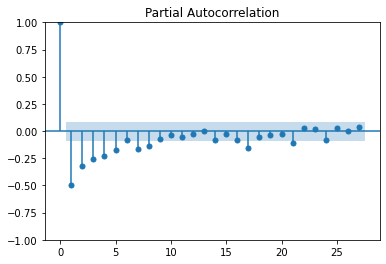

In [77]:
plot_pacf(train.diff().dropna());

In [78]:
df = pd.DataFrame(train)
df.columns = ['lag_0']
df['lag_1'] = train.shift()
df.head()

,lag_0,lag_1
Date_Time,,
1965-01-01,6.183333,NaN
1965-02-01,5.875610,6.183333
1965-03-01,6.052632,5.875610
1965-04-01,5.869231,6.052632
1965-05-01,5.930769,5.869231


In [79]:
gamma_1 = sum(((df['lag_0'][1:]-df['lag_0'][1:].mean()) *\
               (df['lag_1'].dropna()-df['lag_1'].dropna().mean())))/(len(df['lag_1'])-1)
gamma_1

0.003193716358225281

In [80]:
rho = gamma_1/(df.lag_0[1:].std(ddof=0)*df.lag_1.std(ddof=0))
rho

0.15978023369164587

In [81]:
df = pd.DataFrame(train)
df.columns = ['lag_0']
df['lag_1'] = train.shift()
df['lag_2'] = train.shift(2)
df['lag_3'] = train.shift(3)
df['lag_4'] = train.shift(4)
df['lag_5'] = train.shift(5)
df.corr()

,lag_0,lag_1,lag_2,lag_3,lag_4,lag_5
lag_0,1.000000,0.159780,0.152912,0.140931,0.158157,0.188154
lag_1,0.159780,1.000000,0.160217,0.153527,0.141306,0.158074
lag_2,0.152912,0.160217,1.000000,0.159481,0.153044,0.141539
lag_3,0.140931,0.153527,0.159481,1.000000,0.158836,0.153391
lag_4,0.158157,0.141306,0.153044,0.158836,1.000000,0.159041
lag_5,0.188154,0.158074,0.141539,0.153391,0.159041,1.000000


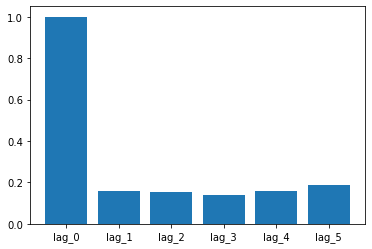

In [82]:
list(df.corr()['lag_0'].index)
plt.bar(list(df.corr()['lag_0'].index), list(df.corr()['lag_0']));

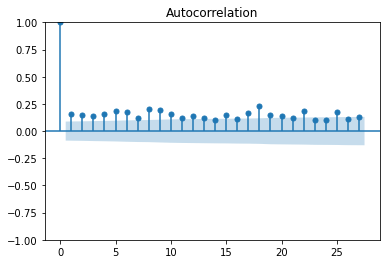

In [83]:
plot_acf(train);

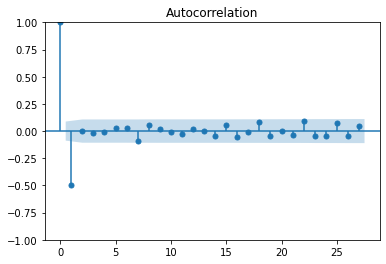

In [84]:
plot_acf(train.diff().dropna());

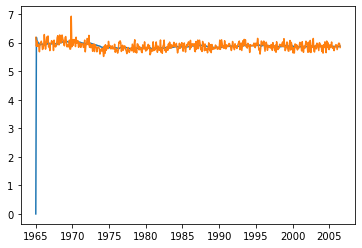

In [85]:
aa_model = ARIMA(train, order=(0, 1, 1)).fit()
y_hat_train = aa_model.predict(typ='levels')

fig, ax = plt.subplots()
ax.plot(y_hat_train)
ax.plot(train);

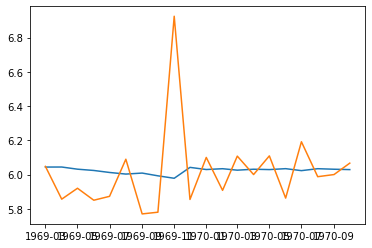

In [86]:
fig, ax = plt.subplots()
ax.plot(y_hat_train[50:70])
ax.plot(train[50:70]);

In [87]:
aa_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Magnitude   No. Observations:                  499
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 295.762
Date:                Tue, 30 Nov 2021   AIC                           -587.524
Time:                        18:03:29   BIC                           -579.103
Sample:                    01-01-1965   HQIC                          -584.219
                         - 07-01-2006                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9328      0.017    -56.106      0.000      -0.965      -0.900
sigma2         0.0178      0.001     26.822      0.000       0.016       0.019
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):               440.10
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               0.59   Skew:                             0.82
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [88]:
test

Date_Time
2006-08-01    5.793333
2006-09-01    5.900000
2006-10-01    5.882353
2006-11-01    5.855556
2006-12-01    5.981818
                ...   
2016-08-01    5.861538
2016-09-01    5.883333
2016-10-01    5.962500
2016-11-01    5.891667
2016-12-01    6.040000
Freq: MS, Name: Magnitude, Length: 125, dtype: float64

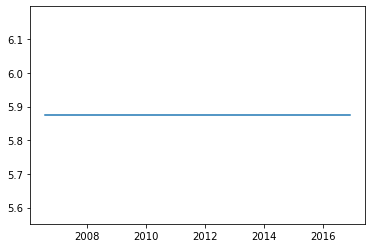

In [89]:
y_hat_test = aa_model.predict(start=test.index[0], end=test.index[-1],typ='levels')

fig, ax = plt.subplots()
ax.plot(y_hat_test);

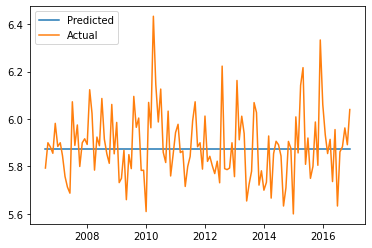

In [90]:
fig, ax = plt.subplots()
ax.plot(y_hat_test)
ax.plot(test)
ax.legend(labels = ['Predicted','Actual']);

In [91]:
np.sqrt(mean_squared_error(test, y_hat_test))

0.1452721880038939

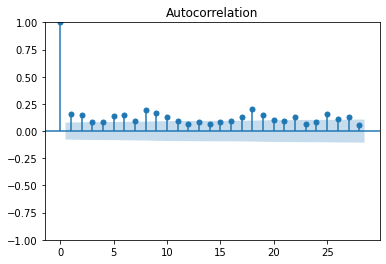

In [92]:
plot_acf(monthly_mean_asian);

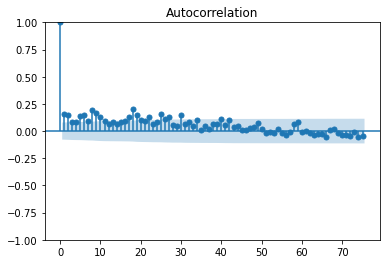

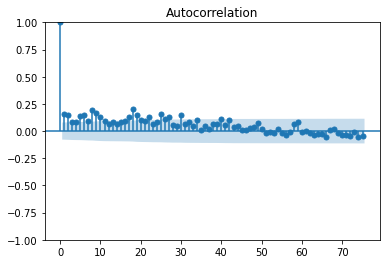

In [93]:
plot_acf(monthly_mean_asian, lags=75)

In [94]:
# p = d = q = range(0, 3)
# pdq = list(itertools.product(p, [1], q))
# seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
# print('Examples of parameters for SARIMA...')
# for i in pdq:  ##  Only turn on when optimizing
#     for s in seasonal_pdq:
#         print('SARIMAX: {} x {}'.format(i, s))

In [95]:
# for param in pdq:  # Only run again if we need to re-optimize
#     for param_seasonal in seasonal_pdq:
#         try:
#             mod=SARIMAX(train,
#                          order=param,
#                          seasonal_order=param_seasonal,
#                          enforce_stationarity=False,
#                          enforce_invertibility=False)
#             results = mod.fit()
#             print('ARIMA{}x{} - AIC:{}'.format(param,param_seasonal,results.aic))
#         except: 
#             print('Oops!')
#             continue

In [96]:
sari_mod =SARIMAX(train,
                  order=(0,1,1),
                  seasonal_order=(0, 1, 1, 12),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()

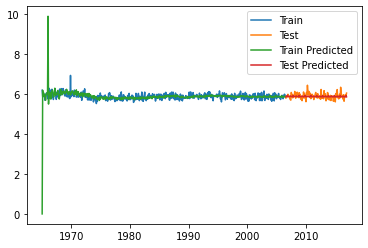

In [97]:
y_hat_train = sari_mod.predict(typ='levels')
y_hat_test = sari_mod.predict(start=test.index[0], end=test.index[-1],typ='levels')

fig, ax = plt.subplots()
ax.plot(train, label='Train')
ax.plot(test, label='Test')
ax.plot(y_hat_train, label='Train Predicted')
ax.plot(y_hat_test, label='Test Predicted')

plt.legend();

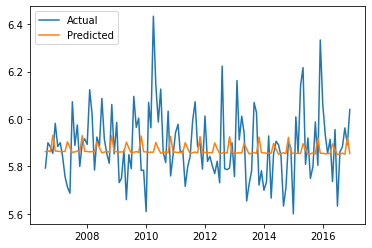

In [98]:
fig, ax = plt.subplots()

ax.plot(test, label='Actual')
ax.plot(y_hat_test, label='Predicted')

plt.legend();

In [99]:
def binning(time_series):
    Magn = {'<6':0,'>=6,<6.5':0,'>=6.5,<7':0,'>=7,<7.5':0,'>=7.5':0}
    for entry in time_series:
        if entry < 6:
            Magn['<6'] += 1
        elif entry >= 6 and entry < 6.5:
            Magn['>=6,<6.5'] += 1
        elif entry >=6.5 and entry < 7:
            Magn['>=6.5,<7'] += 1
        elif entry >= 7 and entry < 7.5:
            Magn['>=7,<7.5'] += 1
        else:
            Magn['>=7.5'] += 1
    return Magn
train_breakdown = binning(train)
test_breakdown = binning(test)
train_len = len(train)
test_len = len(test)
for magn_range in train_breakdown:
    print("Train " + str(magn_range) + ':  ' + str(train_breakdown[magn_range]) + ', ' + str(round((train_breakdown[magn_range]/train_len*100),2)) + "%")
print()
for magn_range in test_breakdown:
    print("Test " + str(magn_range) + ':  ' + str(test_breakdown[magn_range]) + ', ' + str(round((test_breakdown[magn_range]/test_len*100),2)) + "%")

Train <6:  413, 82.77%
Train >=6,<6.5:  85, 17.03%
Train >=6.5,<7:  1, 0.2%
Train >=7,<7.5:  0, 0.0%
Train >=7.5:  0, 0.0%

Test <6:  100, 80.0%
Test >=6,<6.5:  25, 20.0%
Test >=6.5,<7:  0, 0.0%
Test >=7,<7.5:  0, 0.0%
Test >=7.5:  0, 0.0%


In [100]:
train

Date_Time
1965-01-01    6.183333
1965-02-01    5.875610
1965-03-01    6.052632
1965-04-01    5.869231
1965-05-01    5.930769
                ...   
2006-03-01    5.854545
2006-04-01    5.947619
2006-05-01    5.986667
2006-06-01    5.957143
2006-07-01    5.830769
Freq: MS, Name: Magnitude, Length: 499, dtype: float64

In [101]:
np.sqrt(mean_squared_error(train,y_hat_train))

0.3618467480950243

In [102]:
np.sqrt(mean_squared_error(test, y_hat_test))

0.1497660923537459

In [103]:
sari_mod = SARIMAX(monthly_mean_asian,
                  order=(0, 1, 1),
                  seasonal_order=(0, 0, 0, 12), #was 0,1,1
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()

In [104]:
forecast = sari_mod.forecast(steps=24)

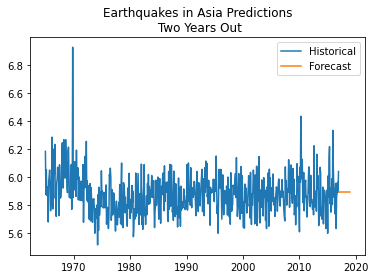

In [105]:
fig, ax = plt.subplots()

ax.plot(monthly_mean_asian, label='Historical')
ax.plot(forecast, label='Forecast')
ax.set_title('Earthquakes in Asia Predictions\n Two Years Out')

plt.legend();

## Trying a SARIMAX to hopefully introduce Lat/Long/Depth into the mix, rather than just Magnitude

In [106]:
# Setting up the different Series
monthly_lat = (pd.Series(df_asian.set_index(df_asian['Date_Time'])['Latitude'])).resample('MS').mean()
monthly_long = (pd.Series(df_asian.set_index(df_asian['Date_Time'])['Longitude'])).resample('MS').mean()
monthly_dep = (pd.Series(df_asian.set_index(df_asian['Date_Time'])['Depth'])).resample('MS').mean()

In [107]:
# Endogenous and Exogenous Variables:
endo = monthly_mean_asian # Magnitude
exo_lat = monthly_lat
exo_long = monthly_long
exo_dep = monthly_dep

In [108]:
# Fitting the models

mod_lat = SARIMAX(endo, exo_lat,
                 order=(0,1,1,),
                 seasonal_order=(0,0,0,12),
                 enforce_stationarity=False,
                 enforce_invertibility=False).fit()

mod_long = SARIMAX(endo, exo_long,
                 order=(0,1,1,),
                 seasonal_order=(0,0,0,12),
                 enforce_stationarity=False,
                 enforce_invertibility=False).fit()

mod_dep = SARIMAX(endo, exo_dep,
                 order=(0,1,1,),
                 seasonal_order=(0,0,0,12),
                 enforce_stationarity=False,
                 enforce_invertibility=False).fit()

mod_lat_long = SARIMAX(exo_lat, exo_long, # exo_lat is the "endo" for this model
                 order=(0,1,1,),
                 seasonal_order=(0,0,0,12),
                 enforce_stationarity=False,
                 enforce_invertibility=False).fit()

In [109]:
print(mod_lat.summary())

                               SARIMAX Results                                
Dep. Variable:              Magnitude   No. Observations:                  624
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 359.002
Date:                Tue, 30 Nov 2021   AIC                           -712.004
Time:                        18:03:31   BIC                           -698.710
Sample:                    01-01-1965   HQIC                          -706.837
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Latitude       0.0014      0.001      2.054      0.040     6.3e-05       0.003
ma.L1         -1.0663      0.016    -64.872      0.000      -1.098      -1.034
sigma2         0.0162      0.001     23.600      0.0

In [110]:
print(mod_long.summary())

                               SARIMAX Results                                
Dep. Variable:              Magnitude   No. Observations:                  624
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 359.297
Date:                Tue, 30 Nov 2021   AIC                           -712.594
Time:                        18:03:31   BIC                           -699.300
Sample:                    01-01-1965   HQIC                          -707.427
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Longitude     -0.0010      0.000     -2.834      0.005      -0.002      -0.000
ma.L1         -0.9362      0.015    -63.616      0.000      -0.965      -0.907
sigma2         0.0184      0.001     23.184      0.0

In [111]:
print(mod_dep.summary())

                               SARIMAX Results                                
Dep. Variable:              Magnitude   No. Observations:                  624
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 356.826
Date:                Tue, 30 Nov 2021   AIC                           -707.652
Time:                        18:03:31   BIC                           -694.358
Sample:                    01-01-1965   HQIC                          -702.485
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Depth      -4.194e-05      0.000     -0.310      0.757      -0.000       0.000
ma.L1         -0.9373      0.015    -64.515      0.000      -0.966      -0.909
sigma2         0.0185      0.001     28.554      0.0

In [112]:
print(mod_lat_long.summary())

                               SARIMAX Results                                
Dep. Variable:               Latitude   No. Observations:                  624
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -2162.168
Date:                Tue, 30 Nov 2021   AIC                           4330.335
Time:                        18:03:31   BIC                           4343.629
Sample:                    01-01-1965   HQIC                          4335.503
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Longitude      0.2447      0.019     13.019      0.000       0.208       0.282
ma.L1         -0.9608      0.012    -81.575      0.000      -0.984      -0.938
sigma2        61.7160      3.526     17.502      0.0

Trying the forecasting using the template from Amber's JN does not work with these exogenous variable models

In [113]:
# forecast_lat = mod_lat.forecast(steps=24)
# forecast_long = mod_long.forecast(steps=24)
# forecast_dep = mode_dep.forecast(steps=24)

Generate list of parameters to test for each SARIMAX model (Magnitude with either Latitude, Longitude or Depth.

In [114]:
'''This was only run once to optimize.  Only uncomment if reoptimization necessary'''
# p = d = q = range(0, 3) # this was a 2 and there was no "d" # Only run once to optimize
# pdq = list(itertools.product(p, d, q)) # "d" was "[1]"
# seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))] #"d" was "[1]"
# print('Examples of parameters for SARIMA...')
# for i in pdq:  ##  Only turn on when optimizing
#     for s in seasonal_pdq:
#         print('SARIMAX: {} x {}'.format(i, s))

'This was only run once to optimize.  Only uncomment if reoptimization necessary'

Finding Optimal SARIMAX parameters for endo='Magnitude', exo = 'Latitude'

In [115]:
'''This was only run once to optimize.  Only uncomment if reoptimization necessary
Optimized was (0,1,1),(0,0,0,12) -> aic = -712.00'''
# for param in pdq:  # Only run again if we need to re-optimize - Best is (0,1,1),(0,0,0,12), aic= -712.00
#     for param_seasonal in seasonal_pdq:
#         try:
#             mod=SARIMAX(endo, exo_lat,
#                          order=param,
#                          seasonal_order=param_seasonal,
#                          enforce_stationarity=False,
#                          enforce_invertibility=False)
#             results = mod.fit()
#             print('ARIMA{}x{} - AIC:{}'.format(param,param_seasonal,results.aic))
#         except: 
#             print('Oops!')
#             continue

'This was only run once to optimize.  Only uncomment if reoptimization necessary\nOptimized was (0,1,1),(0,0,0,12) -> aic = -712.00'

Finding Optimal SARIMAX parameters for endo='Magnitude', exo = 'Longitude'

In [116]:
'''This was only run once to optimize.  Only uncomment if reoptimization necessary
Optimized was (0,1,1),(0,0,0,12) -> aic = -712.59'''
# for param in pdq:  # Only run again if we need to re-optimize - Best is (0,1,1),(0,0,0,12), aic= -712.59
#     for param_seasonal in seasonal_pdq:
#         try:
#             mod=SARIMAX(endo, exo_long,
#                          order=param,
#                          seasonal_order=param_seasonal,
#                          enforce_stationarity=False,
#                          enforce_invertibility=False)
#             results = mod.fit()
#             print('ARIMA{}x{} - AIC:{}'.format(param,param_seasonal,results.aic))
#         except: 
#             print('Oops!')
#             continue

'This was only run once to optimize.  Only uncomment if reoptimization necessary\nOptimized was (0,1,1),(0,0,0,12) -> aic = -712.59'

Finding Optimal SARIMAX parameters for endo='Magnitude', exo = 'Depth'

In [117]:
'''This was only run once to optimize.  Only uncomment if reoptimization necessary
Optimized was (0,1,1),(0,0,0,12) -> aic = -707.65'''
# for param in pdq:  # Only run again if we need to re-optimize - Best is (0,1,1),(0,0,0,12), aic=-707.65
#     for param_seasonal in seasonal_pdq:
#         try:
#             mod=SARIMAX(endo, exo_dep,
#                          order=param,
#                          seasonal_order=param_seasonal,
#                          enforce_stationarity=False,
#                          enforce_invertibility=False)
#             results = mod.fit()
#             print('ARIMA{}x{} - AIC:{}'.format(param,param_seasonal,results.aic))
#         except: 
#             print('Oops!')
#             continue

'This was only run once to optimize.  Only uncomment if reoptimization necessary\nOptimized was (0,1,1),(0,0,0,12) -> aic = -707.65'

### Trying to make a model that uses Magnitude as the endogenous variable, with Latitude and Longitude as combined exogenous variables.  Might add Depth if that becomes a possibility as well, and time permits.

In [118]:
'''
Using info from the following link:
https://stackoverflow.com/questions/44212127/how-do-i-input-multiple-exogenous-variables-into-a-sarimax-model-in-statsmodel
to attempt multi-exogenous variable models.

It has you define the exogenous input as an array with dimensions nobsxk, where nobs = # observations
(ie, how many lines in the time-series data) and k is the number of additional exogenous variables.

'''
# nobs = len(endo)
# k = 2 # for adding lat and long
# emp = np.empty([nobs, k])
# arr = np.append(emp, np.array([[exo_lat][0], [exo_long][0]]).transpose(), axis=1)

# arr2 = np.array([[exo_lat][0], [exo_long][0]]).transpose()

# print(emp)
# print(len(emp))
# print(arr)
# print(len(arr))
# print(exo_lat[0],[exo_long[0]])
# print(len(exo_lat))
# print(arr2)
# print(len(endo))



'\nUsing info from the following link:\nhttps://stackoverflow.com/questions/44212127/how-do-i-input-multiple-exogenous-variables-into-a-sarimax-model-in-statsmodel\nto attempt multi-exogenous variable models.\n\nIt has you define the exogenous input as an array with dimensions nobsxk, where nobs = # observations\n(ie, how many lines in the time-series data) and k is the number of additional exogenous variables.\n\n'

# I don't think I can use monthly means for this, because Latitude and Longitude ranges over a month account for many earthquakes in different parts of asia.  I think the best I can do is use daily means instead.  This still will be prone to a certain amount of error (if there are two earthquakes on the same day in different parts of asia), but we'll just have to deal with that because this is the best I know how to do for now.

## Doing this for all of Asia is appearing to be very slow for the "grid search" process, so I will try just Japan and see how that goes.

In [119]:
df_japan = df_countries[df_countries['Country'] == 'Japan'].reset_index(drop=True)
df_japan = df_japan.drop(drop_indices, axis=1)
df_japan['Date_Time'] = pd.to_datetime(df_japan['Date_Time']).reset_index(drop=True)
print(len(df_japan))

2093


### Toggle the cell below to use Japan data only (make sure to un-toggle the subsequent Markdown cell)

In [120]:
# Setting up the different Series
# daily_magn = (pd.Series(df_japan.set_index(df_japan['Date_Time'])['Magnitude'])).resample('D').mean()
# daily_lat = (pd.Series(df_japan.set_index(df_japan['Date_Time'])['Latitude'])).resample('D').mean()
# daily_long = (pd.Series(df_japan.set_index(df_japan['Date_Time'])['Longitude'])).resample('D').mean()
# daily_dep = (pd.Series(df_japan.set_index(df_japan['Date_Time'])['Depth'])).resample('D').mean()

### Toggle the cell below to use all Asia data (make sure to un-toggle the previous Markdown cell)

In [121]:
daily_magn = (pd.Series(df_asian.set_index(df_asian['Date_Time'])['Magnitude'])).resample('D').mean()
daily_lat = (pd.Series(df_asian.set_index(df_asian['Date_Time'])['Latitude'])).resample('D').mean()
daily_long = (pd.Series(df_asian.set_index(df_asian['Date_Time'])['Longitude'])).resample('D').mean()
daily_dep = (pd.Series(df_asian.set_index(df_asian['Date_Time'])['Depth'])).resample('D').mean()

In [122]:
endo = daily_magn.dropna().reset_index(drop=True)
exo_lat = daily_lat.dropna().reset_index(drop=True)
exo_long = daily_long.dropna().reset_index(drop=True)
exo_dep = daily_dep.dropna().reset_index(drop=True)

In [123]:
# Fitting the models

mod = SARIMAX(endo,
              order=(0,1,1,),
              seasonal_order=(0,0,0,12),
              enforce_stationarity=False,
              enforce_invertibility=False).fit()

mod_lat = SARIMAX(endo, exo_lat,
                 order=(0,1,1,),
                 seasonal_order=(0,0,0,12),
                 enforce_stationarity=False,
                 enforce_invertibility=False).fit()

mod_long = SARIMAX(endo, exo_long,
                 order=(0,1,1,),
                 seasonal_order=(0,0,0,12),
                 enforce_stationarity=False,
                 enforce_invertibility=False).fit()

mod_dep = SARIMAX(endo, exo_dep,
                 order=(0,1,1,),
                 seasonal_order=(0,0,0,12),
                 enforce_stationarity=False,
                 enforce_invertibility=False).fit()

mod_lat_long = SARIMAX(exo_lat, exo_long, # exo_lat is the "endo" for this model
                 order=(0,1,1,),
                 seasonal_order=(0,0,0,12),
                 enforce_stationarity=False,
                 enforce_invertibility=False).fit()

In [124]:
mod_list = [mod,mod_lat,mod_long,mod_dep,mod_lat_long]

In [125]:
for model in mod_list:
    print(model.summary())

                               SARIMAX Results                                
Dep. Variable:              Magnitude   No. Observations:                 6140
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -2406.797
Date:                Tue, 30 Nov 2021   AIC                           4817.594
Time:                        18:03:40   BIC                           4831.039
Sample:                             0   HQIC                          4822.258
                               - 6140                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0070      0.002   -613.023      0.000      -1.010      -1.004
sigma2         0.1264      0.001     88.206      0.000       0.124       0.129
Ljung-Box (L1) (Q):                   1.75   Jarque-

In [126]:
lat_long_array = np.array([[exo_lat][0], [exo_long][0]]).transpose()

In [127]:
'''This was only run once to optimize.  Only uncomment if reoptimization necessary'''
# p = d = q = range(0, 3)
# pdq = list(itertools.product(p, d, q))
# seasonal_pdq = [(0, 0, 0, 365)]
# print('Examples of parameters for SARIMA...')
# for i in pdq:
#     for s in seasonal_pdq:
#         print('SARIMAX: {} x {}'.format(i, s))

'This was only run once to optimize.  Only uncomment if reoptimization necessary'

In [128]:
'''This was only run once to optimize.  Only uncomment if reoptimization necessary
Optimized was (2,1,2),(0,0,0,365) -> aic = 4796.09'''
# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#         try:
#             mod=SARIMAX(endo, lat_long_array,
#                          order=param,
#                          #seasonal_order=param_seasonal,
#                          enforce_stationarity=False,
#                          enforce_invertibility=False)
#             results = mod.fit()
#             print('ARIMA{}x{} - AIC:{}'.format(param,param_seasonal,results.aic))
#         except: 
#             print('Oops!')
#             continue

'This was only run once to optimize.  Only uncomment if reoptimization necessary\nOptimized was (2,1,2),(0,0,0,365) -> aic = 4796.09'

### The best AIC score was for (2,1,2) x (0,0,0,365) => 4796.09
#### Compared to the worst score for (0,0,0) x (0,0,0,365) => 21006.36

In [129]:
mod_lat_long = SARIMAX(endo, lat_long_array,
                       order = (2,1,2),
                       seasonal_order = (0,0,0,365),
                       enforce_stationarity=False,
                       enforce_invertibility=False).fit()

In [130]:
print(mod_lat_long.summary())

                               SARIMAX Results                                
Dep. Variable:              Magnitude   No. Observations:                 6140
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -2391.044
Date:                Tue, 30 Nov 2021   AIC                           4796.088
Time:                        18:03:46   BIC                           4843.142
Sample:                             0   HQIC                          4812.410
                               - 6140                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0007      0.000      3.114      0.002       0.000       0.001
x2            -0.0007      0.000     -4.562      0.000      -0.001      -0.000
ar.L1         -0.8716      0.049    -17.625      0.0

In [131]:
mod_lat_long_alt = SARIMAX(endo, lat_long_array,
                       order = (0,1,1),
                       seasonal_order = (0,0,0,365),
                       enforce_stationarity=False,
                       enforce_invertibility=False).fit()

print(mod_lat_long_alt.summary())

                               SARIMAX Results                                
Dep. Variable:              Magnitude   No. Observations:                 6140
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -2395.481
Date:                Tue, 30 Nov 2021   AIC                           4798.962
Time:                        18:03:48   BIC                           4825.850
Sample:                             0   HQIC                          4808.289
                               - 6140                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0007      0.000      3.160      0.002       0.000       0.001
x2            -0.0007      0.000     -4.629      0.000      -0.001      -0.000
ma.L1         -0.9930      0.002   -612.302      0.0

In [132]:
# New Train/Test:

daily_mean_asian = daily_magn
cutoff = round(daily_mean_asian.shape[0] * 0.8)

In [133]:
train = daily_mean_asian[:cutoff]
test = daily_mean_asian[cutoff:]

Text(0.5, 1.0, 'Train/Test Split')

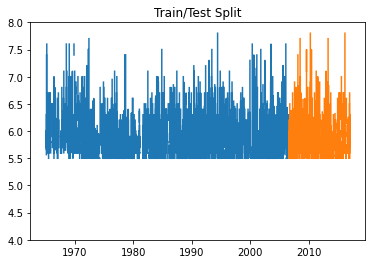

In [134]:
fig, ax = plt.subplots()
ax.plot(train)
ax.plot(test)
ax.set_ylim(4,8)
ax.set_title('Train/Test Split')

In [135]:
arimax_mod = SARIMAX(train,
                    order=(2,1,2),
                    seasonal_order=(0,0,0,365),
                    enforce_stationarity=False,
                    enforce_invertibility=False).fit()

In [136]:
arima_mod = SARIMAX(train,
                   order=(0,1,1),
                   seasonal_order=(0,0,0,365),
                   enforce_stationarity=False,
                   enforce_invertibility=False).fit()

In [137]:
print(arimax_mod.summary())

                               SARIMAX Results                                
Dep. Variable:              Magnitude   No. Observations:                15191
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -1909.606
Date:                Tue, 30 Nov 2021   AIC                           3829.213
Time:                        18:03:56   BIC                           3867.354
Sample:                    01-04-1965   HQIC                          3841.860
                         - 08-07-2006                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5526      0.105      5.243      0.000       0.346       0.759
ar.L2         -0.0050      0.025     -0.201      0.841      -0.053       0.043
ma.L1         -1.5458      0.104    -14.891      0.0

Removing the contribution of Latitude/Longitude from the model produces an AIC about 1000 lower than the model which includes them.  The p-value also improve significantly:

In [138]:
print(arima_mod.summary())

                               SARIMAX Results                                
Dep. Variable:              Magnitude   No. Observations:                15191
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -1903.263
Date:                Tue, 30 Nov 2021   AIC                           3810.527
Time:                        18:03:56   BIC                           3825.783
Sample:                    01-04-1965   HQIC                          3815.586
                         - 08-07-2006                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9957      0.001   -901.617      0.000      -0.998      -0.994
sigma2         0.1263      0.002     79.823      0.000       0.123       0.129
Ljung-Box (L1) (Q):                   0.16   Jarque-

So maybe this is the way to go?

We will continue with the location-adjusted model for now, but we will revisit the above if necessary.

In [139]:
y_hat_train = arimax_mod.predict(typ='levels')
y_hat_test = arimax_mod.predict(start=test.index[0], end=test.index[-1], typ='levels')

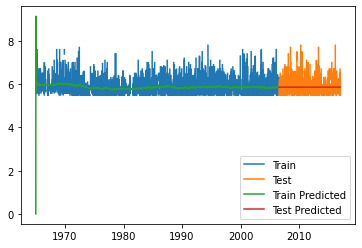

In [140]:
fig, ax = plt.subplots()
ax.plot(train, label='Train')
ax.plot(test, label='Test')
ax.plot(y_hat_train, label='Train Predicted')
ax.plot(y_hat_test, label='Test Predicted')
plt.legend();

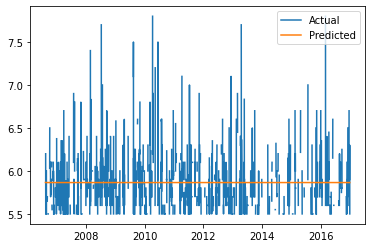

In [141]:
fig, ax = plt.subplots()

ax.plot(test, label='Actual')
ax.plot(y_hat_test, label='Predicted')
plt.legend();

In [142]:
test

Date_Time
2006-08-08    NaN
2006-08-09    NaN
2006-08-10    NaN
2006-08-11    6.2
2006-08-12    5.5
             ... 
2016-12-26    NaN
2016-12-27    NaN
2016-12-28    5.9
2016-12-29    6.3
2016-12-30    5.5
Freq: D, Name: Magnitude, Length: 3798, dtype: float64

In [143]:
y_hat_test

2006-08-08    5.865763
2006-08-09    5.865391
2006-08-10    5.865183
2006-08-11    5.865070
2006-08-12    5.865009
                ...   
2016-12-26    5.864936
2016-12-27    5.864936
2016-12-28    5.864936
2016-12-29    5.864936
2016-12-30    5.864936
Freq: D, Name: predicted_mean, Length: 3798, dtype: float64

In [144]:
temp_df = pd.DataFrame(test)
temp_df['y_hat_test'] = y_hat_test
temp_df.dropna(inplace=True)
temp_df.head()

,Magnitude,y_hat_test
Date_Time,,
2006-08-11,6.20,5.865070
2006-08-12,5.50,5.865009
2006-08-15,5.90,5.864948
2006-08-17,5.65,5.864940
2006-08-20,6.00,5.864937


In [145]:
temp_df.reset_index(level=0, inplace=True)
temp_df.head()

,Date_Time,Magnitude,y_hat_test
0,2006-08-11,6.20,5.865070
1,2006-08-12,5.50,5.865009
2,2006-08-15,5.90,5.864948
3,2006-08-17,5.65,5.864940
4,2006-08-20,6.00,5.864937


In [146]:
test = (pd.Series(temp_df.set_index(temp_df['Date_Time'])['Magnitude'])).resample('D').mean()
y_hat_test = (pd.Series(temp_df.set_index(temp_df['Date_Time'])['y_hat_test'])).resample('D').mean()

In [147]:
np.sqrt(mean_squared_error(test.dropna(), y_hat_test.dropna()))

0.36544956031789816

In [148]:
arimax_mod = SARIMAX(daily_mean_asian,
                    order=(2,1,2),
                    seasonal_order=(0,0,0,365),
                    enforce_stationarity=False,
                    enforce_invertibility=False).fit()

In [149]:
forecast = arimax_mod.forecast(steps=730)

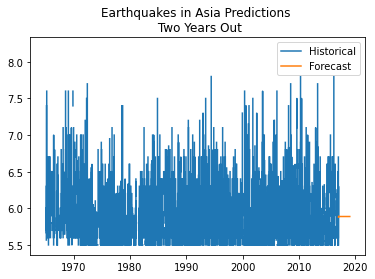

In [150]:
fig, ax = plt.subplots()

ax.plot(daily_mean_asian, label='Historical')
ax.plot(forecast, label='Forecast')
ax.set_title('Earthquakes in Asia Predictions \n Two Years Out')

plt.legend();